In [80]:
%matplotlib inline


# 02 Random Forest regression

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from datetime import datetime
import os

pd.set_option('display.max_columns', 30)
pd.set_option('display.precision', 3)

## Time-independent regression with `df_X_pca` and `df_y`




In [9]:
df_X_pca = pd.read_pickle('df_X_pca.pkl')
X_cols = df_X_pca.columns

df_y = pd.read_pickle('df_y.pkl')
y_cols = df_y.columns

X = df_X_pca.to_numpy()
y = df_y.to_numpy()

print('X.shape = ', X.shape, ', y.shape = ', y.shape)

X.shape =  (1229, 50) , y.shape =  (1229, 6)


### Train-val-test split

Even when attempting time-independent regression, we cannot shuffle the data set before making train and test plit. If the model should be able to predict output variables ahead in time, it has to work well on a chronologically split data set.

For validation during training, the Random Forest class of sklearn.ensemble out-of-bag set for validation given `oob_score=True` and therefore does not need a defined validation set.


In [10]:
split_test = int(len(X)*0.8)
X_train, X_test = X[:split_test,:], X[split_test+1:,:]
y_train, y_test = y[:split_test,:], y[split_test+1:,:]

print('X_train:', X_train.shape, 'X_test:', X_test.shape)
print('y_train:', y_train.shape, 'y_test:', y_test.shape)

Note = 'PCA50. Random train/val but end as test.'

X_train: (983, 50) X_test: (245, 50)
y_train: (983, 6) y_test: (245, 6)


In [11]:
params = {
    "n_estimators": 200,
    "max_depth": 30,
    "min_samples_split": 3,
    "criterion": "friedman_mse", #criterion{“squared_error”, “absolute_error”, “poisson”}, default=”squared_error”
    "oob_score": True, # Calculate out-of-bag score of predictor
    "n_jobs": 1, # Number of parallel jobs
    "max_samples": 0.9, # Amount of data to train each tree
}

### Fit regression model


In [14]:
# Prepare dataframe of rmse results and parameter values, or load existing dataframe from file if `fit_file`exists

fit_file = '02_fitting_results.pkl' # NB: Update name according to notebook number

if os.path.exists(fit_file):
    fit_results = pd.read_pickle(fit_file)
else:
    res_cols = ['Note']
    for col in df_y.columns:
        res_cols.append(col+' S_e')
    res_cols.append('S_e mean')
    for key in params.keys():
        res_cols.append(key)
    res_cols.append('Training time')
        
    fit_results = pd.DataFrame(columns=res_cols)


start_time = datetime.now()


# ----------------- Calculate root mean squared error of predictions and -------------------------
# ----------------- store results in dataframe together with parameter values used -------------------------
res_labels = ['Note']
res_values = [Note]

regs = []
y_test_estimated = []
y_test_error = []
S_e_values = []

for i in range(y_train.shape[1]):
    reg = RandomForestRegressor(**params, verbose=1) 
    history = reg.fit(X_train, y_train[:,i]) # Fit model for label i
    regs.append(reg)

    y_test_estimated.append(reg.predict(X_test)) # Predict label values on test set
    y_test_error.append(y_test[:,i] - y_test_estimated[i])
    S_e = np.std(y_test_error[i])/np.std(y_test[:,i])
    res_values.append(S_e)
    label = y_cols[i]
    res_labels.append(label+' S_e')
    
    S_e_values.append(S_e)

res_labels.append('S_e mean')
res_values.append(np.mean(S_e_values))

for key in params.keys():
    res_values.append(params[key])
    res_labels.append(key)

training_time = (datetime.now() - start_time).total_seconds()
res_values.append(training_time)
res_labels.append('Training time')

df_tmp = pd.DataFrame([res_values], columns=res_labels, index=[datetime.now().date()])
fit_results = fit_results.append(df_tmp)
#fit_results = fit_results.sort_values('R2', ascending=False)
fit_results.to_pickle(fit_file)
fit_results

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    5.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

,Note,y1 S_e,y2 S_e,y3 S_e,y4 S_e,y5 S_e,y6 S_e,S_e mean,n_estimators,max_depth,min_samples_split,criterion,oob_score,n_jobs,max_samples,Training time
2023-02-17,PCA50. Random train/val but end as test.,1.107,0.705,1.047,0.79,0.801,0.942,0.899,200,30,3,friedman_mse,True,1,0.9,28.705


## Time dependent regression with `df_X_lagged` and `df_y_lagged`

The reason for not using `df_y` here is that `df_X_lagged` contains fewer rows and we need a coherent set of labels



In [15]:
df_X_lagged = pd.read_pickle('df_X_lagged.pkl')
X_cols = df_X_pca.columns

df_y_lagged = pd.read_pickle('df_y_lagged.pkl')
y_cols = df_y.columns

X = df_X_lagged.to_numpy()
y = df_y_lagged.to_numpy()

print('X.shape = ', X.shape, ', y.shape = ', y.shape)

X.shape =  (1224, 330) , y.shape =  (1224, 6)


### Train-val-test split


In [16]:
split_test = int(len(X)*0.8)
X_train, X_test = X[:split_test,:], X[split_test+1:,:]
y_train, y_test = y[:split_test,:], y[split_test+1:,:]

print('X_train:', X_train.shape, 'X_test:', X_test.shape)
print('y_train:', y_train.shape, 'y_test:', y_test.shape)

Note = 'df_X_lagged. Random train/val but end as test.'

X_train: (979, 330) X_test: (244, 330)
y_train: (979, 6) y_test: (244, 6)


### Fit regression model


In [17]:
# Prepare dataframe of rmse results and parameter values, or load existing dataframe from file if `fit_file`exists

fit_file = '02_fitting_results.pkl' # NB: Update name according to notebook number

if os.path.exists(fit_file):
    fit_results = pd.read_pickle(fit_file)
else:
    res_cols = ['Note']
    for col in df_y.columns:
        res_cols.append(col+' S_e')
    res_cols.append('S_e mean')
    for key in params.keys():
        res_cols.append(key)
    res_cols.append('Training time')
        
    fit_results = pd.DataFrame(columns=res_cols)


start_time = datetime.now()


# ----------------- Calculate root mean squared error of predictions and -------------------------
# ----------------- store results in dataframe together with parameter values used -------------------------
res_labels = ['Note']
res_values = [Note]

regs = []
y_test_estimated = []
y_test_error = []
S_e_values = []

for i in range(y_train.shape[1]):
    reg = RandomForestRegressor(**params, verbose=1) 
    history = reg.fit(X_train, y_train[:,i]) # Fit model for label i
    regs.append(reg)

    y_test_estimated.append(reg.predict(X_test)) # Predict label values on test set
    y_test_error.append(y_test[:,i] - y_test_estimated[i])
    S_e = np.std(y_test_error[i])/np.std(y_test[:,i])
    res_values.append(S_e)
    label = y_cols[i]
    res_labels.append(label+' S_e')
    
    S_e_values.append(S_e)

res_labels.append('S_e mean')
res_values.append(np.mean(S_e_values))

for key in params.keys():
    res_values.append(params[key])
    res_labels.append(key)

training_time = (datetime.now() - start_time).total_seconds()
res_values.append(training_time)
res_labels.append('Training time')

df_tmp = pd.DataFrame([res_values], columns=res_labels, index=[datetime.now().date()])
fit_results = fit_results.append(df_tmp)
#fit_results = fit_results.sort_values('R2', ascending=False)
fit_results.to_pickle(fit_file)
fit_results

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   52.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   27.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   30.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

,Note,y1 S_e,y2 S_e,y3 S_e,y4 S_e,y5 S_e,y6 S_e,S_e mean,n_estimators,max_depth,min_samples_split,criterion,oob_score,n_jobs,max_samples,Training time
2023-02-17,PCA50. Random train/val but end as test.,1.107,0.705,1.047,0.790,0.801,0.942,0.899,200,30,3,friedman_mse,True,1,0.9,28.705
2023-02-17,df_X_lagged. Random train/val but end as test.,0.908,0.758,0.884,0.741,0.746,0.782,0.803,200,30,3,friedman_mse,True,1,0.9,190.675


Text(0.5, 0, 'index')

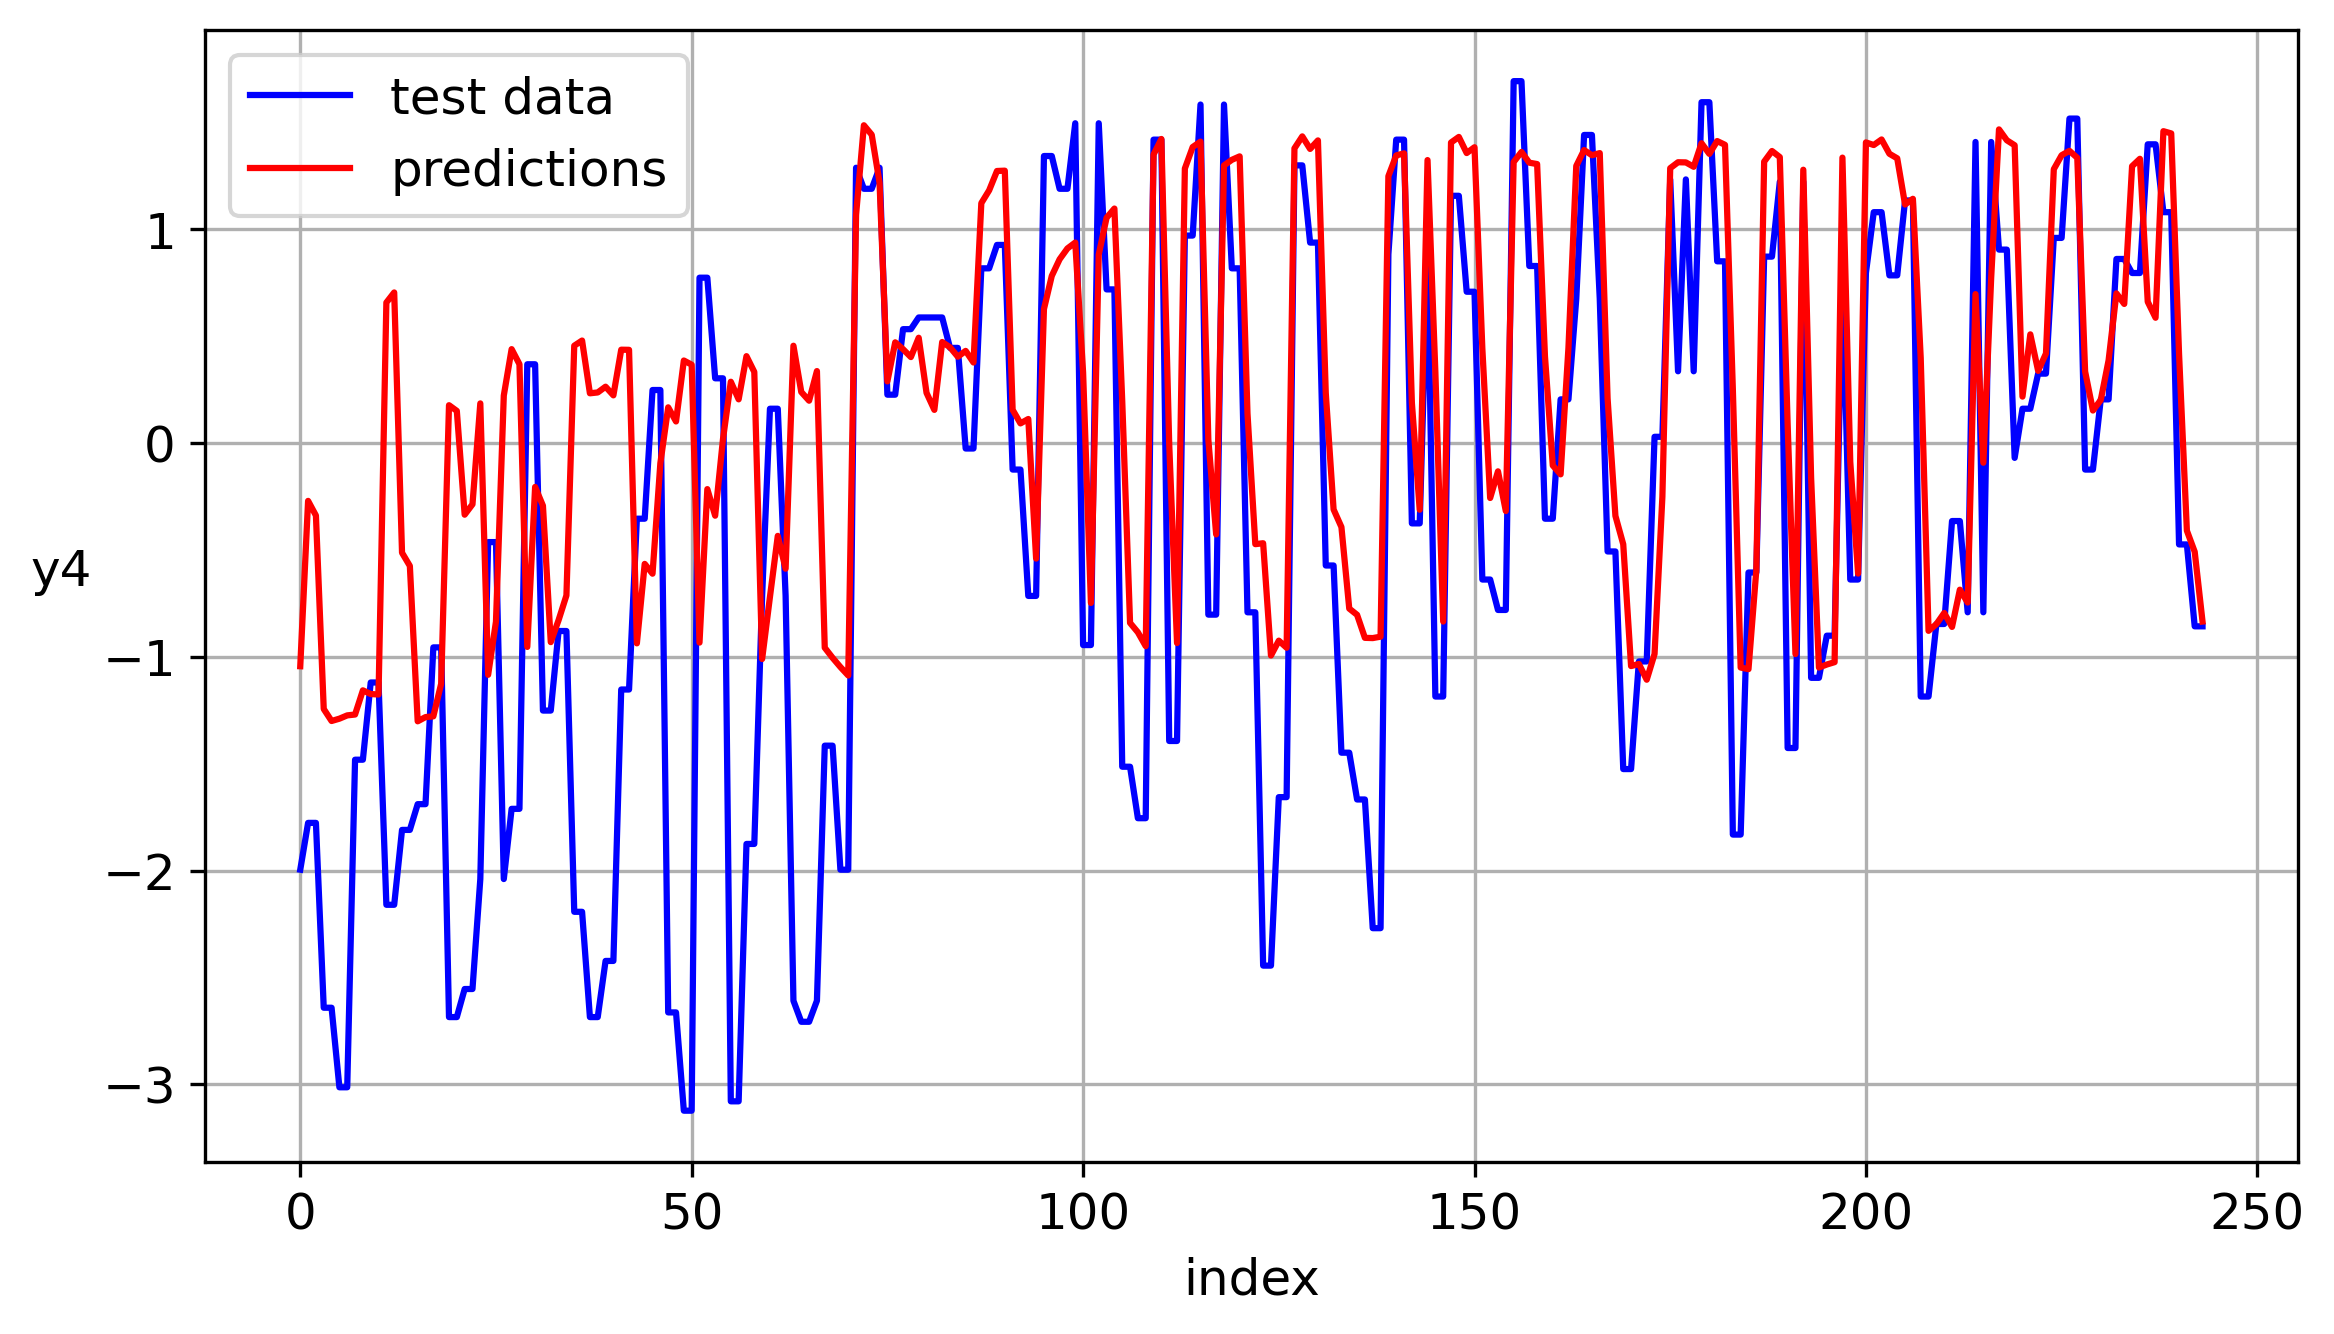

In [39]:
plt.rcParams["font.size"] = 12
plt.figure(dpi=300)

label_no = 3
split_test = int(len(X)*0.8)
idx = np.arange(len(y_test[:,label_no]))

plt.plot(idx, y_test[:,label_no], color='b', label='test data')
plt.plot(idx, y_test_estimated[label_no], color='r', label='predictions')
plt.gcf().set_size_inches(9,5)
plt.grid()
plt.legend()

plt.ylabel('y'+str(label_no+1), rotation=0, labelpad=10)
plt.xlabel('index')
#plt.savefig('test_estimate_RF.png')


Text(0.5, 0, 'y4 test data')

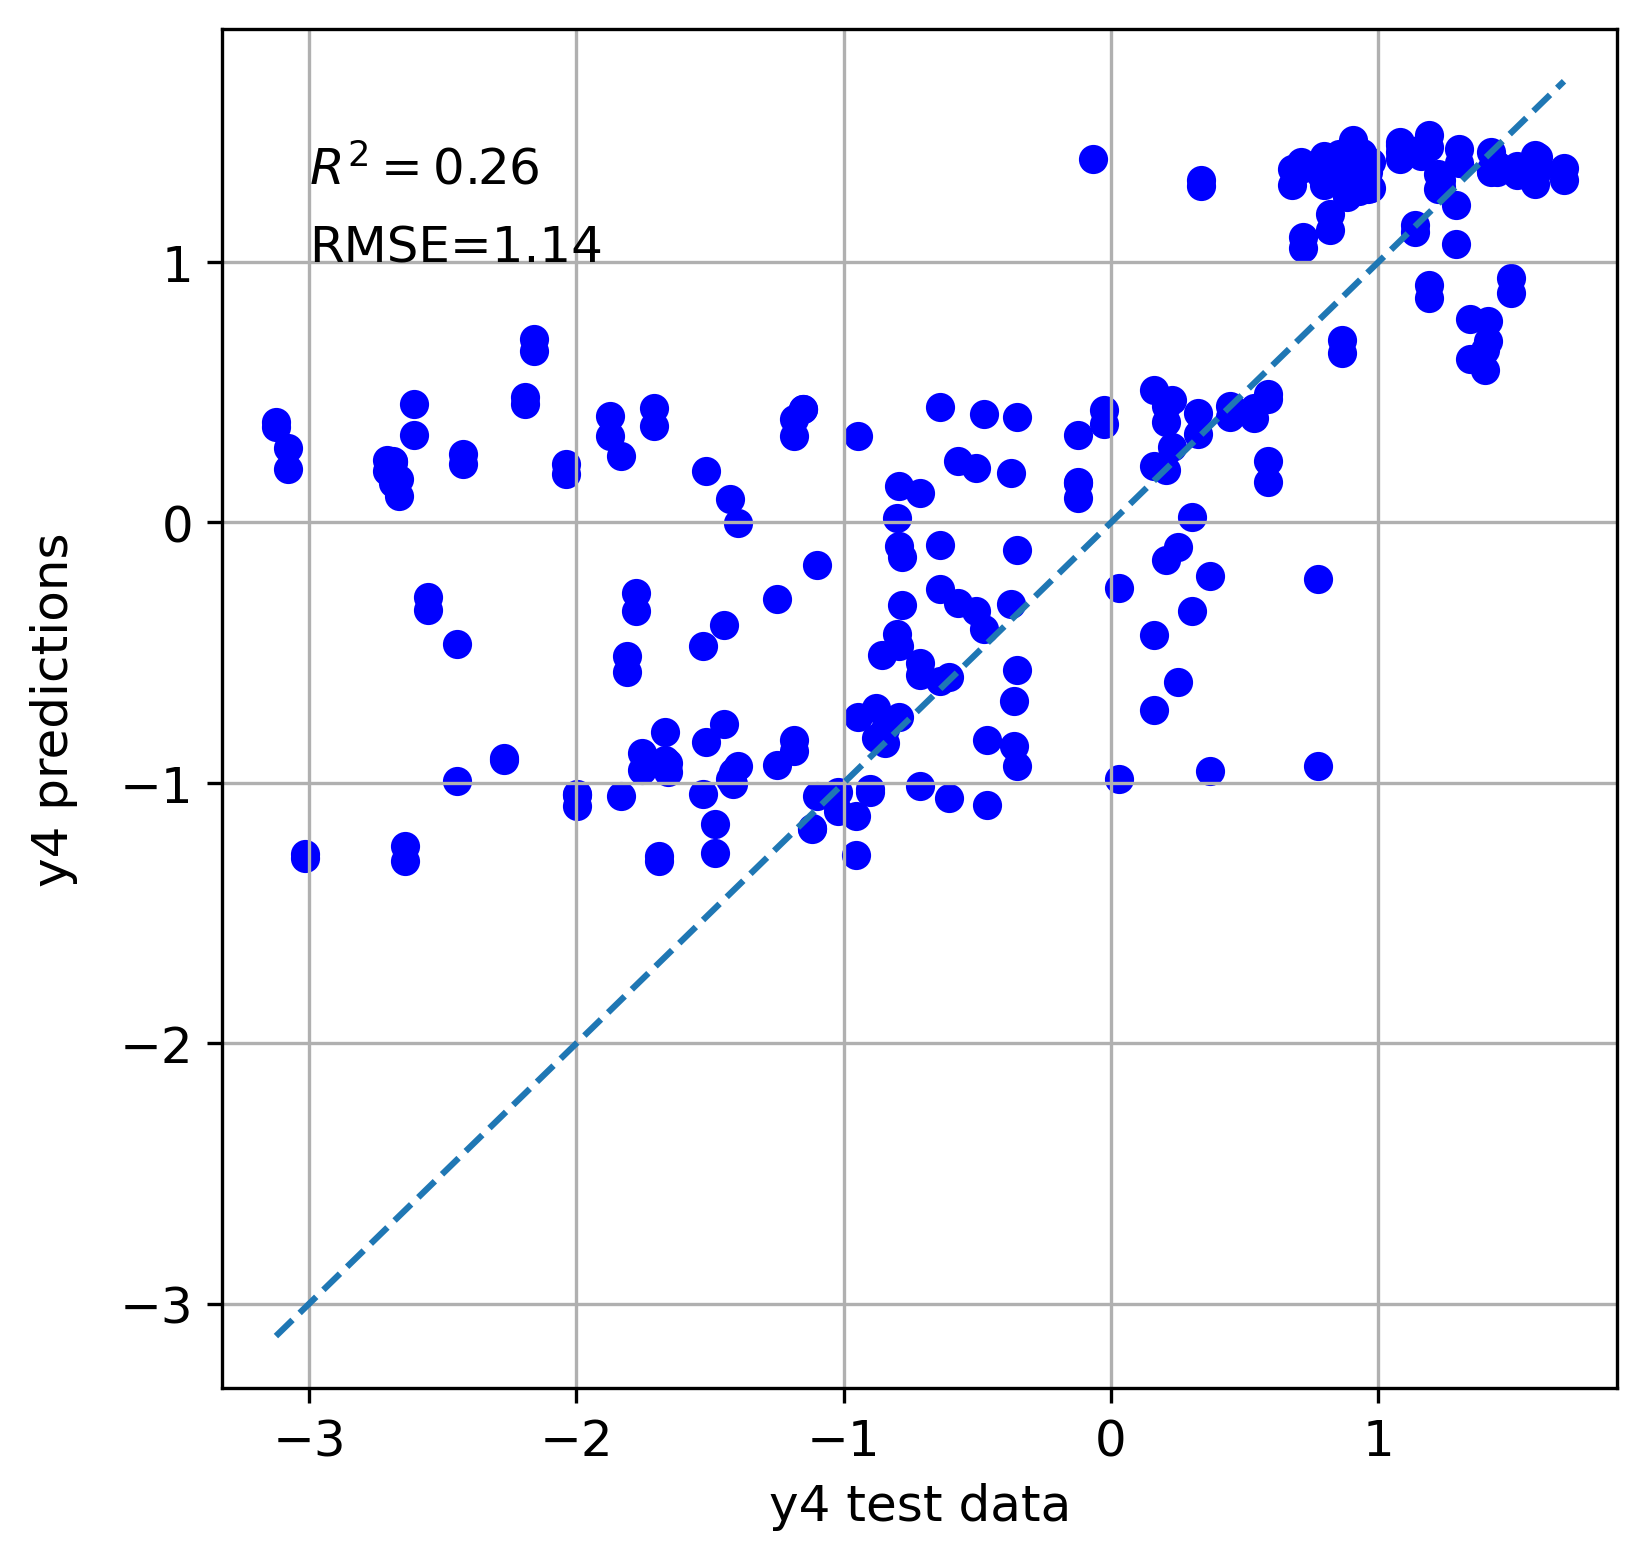

In [52]:
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt

plt.rcParams["font.size"] = 12
plt.figure(dpi=300)

label_no = 3
split_test = int(len(X)*0.8)
idx = np.arange(len(y_test[:,label_no]))

r2 = r2_score(y_test[:,label_no], y_test_estimated[label_no])
rmse = sqrt(mean_squared_error(y_test[:,label_no], y_test_estimated[label_no]))


xmin = np.min(y_test[:,label_no])
xmax = np.max(y_test[:,label_no])

plt.scatter(y_test[:,label_no], y_test_estimated[label_no], color='b')
plt.plot([xmin, xmax], [xmin, xmax], linestyle='dashed')
plt.gcf().set_size_inches(6,6)
plt.grid()
plt.xlim(xmin-0.2, xmax+0.2)
plt.ylim(xmin-0.2, xmax+0.2)

plt.text(s=f'$R^2=${r2:0.2f}', x=-3, y=1.3)
plt.text(s=f'RMSE={rmse:0.2f}', x=-3, y=1)

plt.ylabel('y'+str(label_no+1)+' predictions', rotation=90, labelpad=10)
plt.xlabel('y'+str(label_no+1)+' test data')
#plt.savefig('test_estimate_RF.png')

In [19]:
fit_results.to_latex(columns=['y1 S_e', 'y2 S_e', 'y3 S_e', 'y4 S_e', 'y5 S_e', 'y6 S_e', 'S_e mean'], buf='fit_res_RF.tex')

C:\Users\christiano\AppData\Local\Temp\ipykernel_19708\3396377828.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  fit_results.to_latex(columns=['y1 S_e', 'y2 S_e', 'y3 S_e', 'y4 S_e', 'y5 S_e', 'y6 S_e', 'S_e mean'], buf='fit_res_RF.tex')


Grid search hyperparameter tuning

In [ ]:
df_X_lagged = pd.read_pickle('df_X_lagged.pkl')
X_cols = df_X_pca.columns

df_y_lagged = pd.read_pickle('df_y_lagged.pkl')
y_cols = df_y.columns

X = df_X_lagged.to_numpy()
y = df_y_lagged.to_numpy()


split_test = int(len(X)*0.8)
X_train, X_test = X[:split_test,:], X[split_test+1:,:]
y_train, y_test = y[:split_test,3], y[split_test+1:,3]

print('X_train:', X_train.shape, 'X_test:', X_test.shape)
print('y_train:', y_train.shape, 'y_test:', y_test.shape)

In [ ]:
from sklearn.model_selection import GridSearchCV

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

params = {
        'min_samples_split': [2, 3, 5, 10],
        'max_depth': [5, 10, 20, 30],
        'criterion': ["squared_error", "friedman_mse"],
        'max_samples': [0.7, 0.8, 0.9]
        }

rf = RandomForestRegressor(n_estimators=200, oob_score=True,
                 random_state=42, )
folds = 3
param_comb = 4
kf = KFold(n_splits=folds, shuffle=True, random_state=42)
grid = GridSearchCV(estimator=rf, param_grid=params, scoring='neg_root_mean_squared_error', n_jobs=40, cv=kf.split(X_train,y_train), verbose=3)

start_time = timer(None)
grid.fit(X_train, y_train)
timer(start_time)

results = pd.DataFrame(grid.cv_results_)
results.to_csv('gb-grid-search-results-01.csv', index=False)

In [8]:
import pandas as pd
params = {
        'min_samples_split': ["2, 3, 5, 10", 3],
        'max_depth': ["5, 10, 20, 30", 30],
        'criterion': ["squared_error, friedman_mse", "friedman_mse"],
        'max_samples': ["0.7, 0.8, 0.9", 0.9]
        }
GS_res = pd.DataFrame(params, index = ["", "result"]).T
GS_res.to_latex(buf='GS_res_RF.tex')
GS_res

C:\Users\christiano\AppData\Local\Temp\ipykernel_19708\3273398343.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  GS_res.to_latex(buf='GS_res_RF.tex')


,,result
min_samples_split,"2, 3, 5, 10",3
max_depth,"5, 10, 20, 30",30
criterion,"squared_error, friedman_mse",friedman_mse
max_samples,"0.7, 0.8, 0.9",0.9
